In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from openbb_terminal.sdk import openbb
from scipy.stats import spearmanr

In [2]:
plt.style.use("default")
plt.rcParams["figure.figsize"] = [5.5, 4.0]
plt.rcParams["figure.dpi"] = 140
plt.rcParams["lines.linewidth"] = 0.75
plt.rcParams["font.size"] = 8

In [3]:
symbols = ["NEM", "RGLD", "SSRM", "CDE", "LLY", "UNH", "JNJ", "MRK"]
stocks = []
for symbol in symbols:
    df = (
        openbb
        .stocks
        .load(
            symbol,
            start_date="2015-01-01", 
            end_date="2022-12-31",
            verbose=False
        )
        .drop(["Close", "Dividends", "Stock Splits"], axis=1)
    )
    df["symbol"] = symbol
    stocks.append(df)

prices = pd.concat(stocks)
prices.columns = ["open", "high", "low", "close", "volume", "symbol"]

In [4]:
nobs = prices.groupby("symbol").size()
mask = nobs[nobs > 2 * 12 * 21].index
prices = prices[prices.symbol.isin(mask)]

In [5]:
prices = (
    prices
    .set_index("symbol", append=True)
    .reorder_levels(["symbol", "date"])
).drop_duplicates()

In [6]:
def parkinson(data, window=14, trading_days=252):

    rs = (1.0 / (4.0 * np.log(2.0))) * ((data.high / data.low).apply(np.log))**2.0

    def f(v):
        return (trading_days * v.mean())**0.5
    
    result = rs.rolling(
        window=window,
        center=False
    ).apply(func=f)
    
    return result.sub(result.mean()).div(result.std())

In [10]:
prices["vol"] = (
    prices
    .groupby("symbol", group_keys=False)
    .apply(parkinson)
)
prices.dropna(inplace=True)

In [11]:
lags = [1, 5, 10, 21, 42, 63]
for lag in lags:
    prices[f"return_{lag}d"] = (
        prices
        .groupby(level="symbol")
        .close
        .pct_change(lag)
    )

In [12]:
for t in [1, 5, 10, 21, 42, 63]:
    prices[f"target_{t}d"] = (
        prices
        .groupby(level="symbol")[f"return_{t}d"]
        .shift(-t)
    )

7.39% (0.00%)


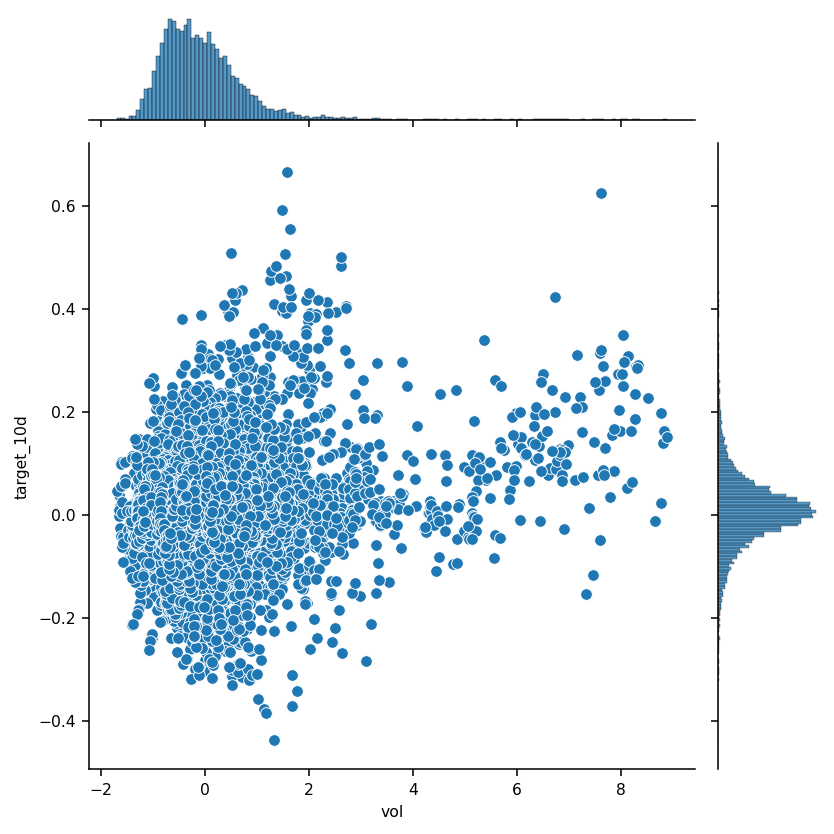

In [13]:
target = "target_10d"
metric = "vol"
j = sns.jointplot(x=metric, y=target, data=prices)
plt.tight_layout()
df = prices[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f"{r:,.2%} ({p:.2%})")

In [14]:
r, p = spearmanr(df[metric], df[target])

In [15]:
r, p

(0.07389281266676159, 9.8389395716224e-21)